# Summary of this notebook

In this notebook, we will make melspectrogram multilabel classifier models.

# Input & Output of this notebook

[input]

7sec clip melspectrogram images of train_short_audio 

(generated by kkiller's notebook https://www.kaggle.com/kneroma/birdclef-mels-computer-public)

https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part1

https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part2

https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part3

https://www.kaggle.com/kneroma/kkiller-birdclef-mels-computer-d7-part4

BirdCLEF2020 data

https://www.kaggle.com/kami634/birdclef2020-validation-audio-and-ground-truth-d5

freefield1010

https://www.kaggle.com/startjapan/ff1010bird-duration7-1

nocall detector output for train_short_audio

https://www.kaggle.com/startjapan/train-short-audio-nocall-fold0to4

sklearn library (To use StratifiedGroupKfold, we have to install scikit-learn 1.0.dev0)

https://www.kaggle.com/namakemono/scikit-learn-10dev0


[output]

melspectrogram multilabel classifier models are outputted.

# To reproduce the same models
Hyperparams are like below.
At this time, they are the same as model1.
(except for epochs)

model1 (id36)

`
mixup_alpha = 0.5
epochs = 27
fold = 0
grouped_by_author = False
use_valid2020 = False
use_ff1010 = False
`

model2 (id51)

`
mixup_alpha = 5.0
epochs = 13
fold = 0
grouped_by_author = False
use_valid2020 = False
use_ff1010 = False
`

model3 (id58)

`
mixup_alpha = 5.0
epochs = 33
fold = 0
grouped_by_author = True
use_valid2020 = False
use_ff1010 = False
`

model4 (id59)

`
mixup_alpha = 5.0
epochs = 34
fold =1
grouped_by_author = True
use_valid2020 = False
use_ff1010 = False
`

model5 (id60)

`
mixup_alpha = 5.0
epochs = 34
fold = 2
grouped_by_author = True
use_valid2020 = False
use_ff1010 = False
`


model6 (id61)

`
mixup_alpha = 5.0
epochs = 20
fold = 3
grouped_by_author = True
use_valid2020 = False
use_ff1010 = False
`


model7 (id62)

`
mixup_alpha = 5.0
epochs = 34
fold = 4
grouped_by_author = True
use_valid2020 = False
use_ff1010 = False
`


model8 (id)

`
mixup_alpha = 5.0
epochs = 78
fold = 0
grouped_by_author = True
use_valid2020 = False
use_ff1010 = False
`

model9 (id97)

`
mixup_alpha = 5.0
epochs = 84
fold = 0
grouped_by_author = True
use_valid2020 = True
use_ff1010 = True
`

model10 (id98)

`
mixup_alpha = 5.0
epochs = 27
fold = 1
grouped_by_author = True
use_valid2020 = True
use_ff1010 = True
`

In [31]:
!pip install -q pysndfx SoundFile audiomentations pretrainedmodels efficientnet_pytorch resnest
!pip install timm

In [32]:
from pathlib import Path

INPUT = Path('../input/')

In [33]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader

from resnest.torch import resnest50

from matplotlib import pyplot as plt
import timm
import os, random, gc
import re, time, json
from  ast import literal_eval


from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib
import glob

from efficientnet_pytorch import EfficientNet
import pretrainedmodels
import resnest.torch as resnest_torch

!pip install ../input/scikit-learn-10dev0/scikit_learn-1.0.dev0-cp37-cp37m-manylinux2010_x86_64.whl
from sklearn.model_selection import StratifiedGroupKFold

Processing /kaggle/input/scikit-learn-10dev0/scikit_learn-1.0.dev0-cp37-cp37m-manylinux2010_x86_64.whl
scikit-learn is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [34]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [35]:
NUM_CLASSES = 397
SR = 32_000
DURATION = 7

MAX_READ_SAMPLES = 10 # Each record will have 10 melspecs at most, you can increase this on Colab with High Memory Enabled

In [36]:
class Config:
    def __init__(self, debug:bool):
        self.debug = debug
        
        self.epochs = 1 if self.debug else 100 # 50

        self.max_distance = None # choose from [10, 20, None]
        if self.max_distance is not None:
            self.sites = ["SSW"] # choose multiples from ["COL", "COR", "SNE", "SSW"]
        else:
            self.sites = None
        self.max_duration = None # choose from [15, 30, 60, None]
        self.min_rating = None # choose from [3, 4, None], best: 3?
        self.max_spieces = None # choose from [100, 200, 300, None], best: 300?
        self.confidence_ub = 0.995 # Probability of birdsong occurrence, default: 0.995, choose from [0.5, 0.7, 0.9, 0.995]
        self.use_high_confidence_only = False # Whether to use only frames that are likely to be ringing (False performed better).
        self.use_mixup = True
        self.mixup_alpha = 0.5 # 5.0
        self.secondary_labels_weight = 0.6 #0.6 > 0.8 > 0.3 for better performance
        self.grouped_by_author = False
        self.folds = [0,]

        self.use_weight = False
        self.use_valid2020 = False
        self.use_ff1010 = False

        self.suffix = f"_sr{SR}_d{DURATION}"
        if self.max_spieces:
            self.suffix += f"_spices-{self.max_spieces}"
        if self.min_rating:
            self.suffix += f"_rating-{self.min_rating}"
        if self.use_high_confidence_only:
            self.suffix += f"_high-confidence-only"
        if self.use_mixup:
            self.suffix += f"_miixup-{self.mixup_alpha}"
        if self.secondary_labels_weight:
            self.suffix += f"_2ndlw-{self.secondary_labels_weight}"
        if self.use_weight:
            self.suffix += f"_weight"
        if self.use_valid2020:
            self.suffix += f"_valid2020"
        if self.use_ff1010:
            self.suffix += f"_ff1010"
        if self.grouped_by_author:
            self.suffix += f"_grouped-by-auther"

    def to_dict(self):
        return {
            "debug": self.debug,
            "epochs": self.epochs,
            "max_distance": self.max_distance,
            "sites": self.sites,
            "max_duration": self.max_duration,
            "min_rating": self.min_rating,
            "max_spieces": self.max_spieces,
            "confidence_ub": self.confidence_ub,
            "use_high_confidence_only": self.use_high_confidence_only,
            "use_mixup": self.use_mixup,
            "mixup_alpha": self.mixup_alpha,
            "secondary_labels_weight": self.secondary_labels_weight,
            "suffix": self.suffix,
            "grouped_by_author": self.grouped_by_author
        }

config = Config(debug=True)
from pprint import pprint
pprint(config.to_dict())

{'confidence_ub': 0.995,
 'debug': True,
 'epochs': 1,
 'grouped_by_author': False,
 'max_distance': None,
 'max_duration': None,
 'max_spieces': None,
 'min_rating': None,
 'mixup_alpha': 0.5,
 'secondary_labels_weight': 0.6,
 'sites': None,
 'suffix': '_sr32000_d7_miixup-0.5_2ndlw-0.6',
 'use_high_confidence_only': False,
 'use_mixup': True}


In [37]:
MODEL_NAMES = [
    # "resnext101_32x8d_wsl",
    # "resnest50",
    "resnest26d",
    # "tf_efficientnet_b0",
] 

In [38]:
MEL_PATHS = sorted(INPUT.glob("kkiller-birdclef-mels-computer-d7-part?/rich_train_metadata.csv"))
TRAIN_LABEL_PATHS = sorted(INPUT.glob("kkiller-birdclef-mels-computer-d7-part?/LABEL_IDS.json"))

MODEL_ROOT = Path(".")

In [39]:
TRAIN_BATCH_SIZE = 64
TRAIN_NUM_WORKERS = 2

VAL_BATCH_SIZE = 64
VAL_NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cuda


In [40]:
def get_df(mel_paths=MEL_PATHS, train_label_paths=TRAIN_LABEL_PATHS):
  df = None
  LABEL_IDS = {}
    
  for file_path in mel_paths:
    temp = pd.read_csv(str(file_path), index_col=0)
    temp["impath"] = temp.apply(lambda row: file_path.parent/"audio_images/{}/{}.npy".format(row.primary_label, row.filename), axis=1) 
    df = temp if df is None else df.append(temp)
    
  df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)

  for file_path in train_label_paths:
    with open(str(file_path)) as f:
      LABEL_IDS.update(json.load(f))

  return LABEL_IDS, df

In [41]:
from typing import List
def get_locations() -> List[dict]:
    return [{
        "site": "COL",
        "latitude": 5.57,
        "longitude": -75.85
    }, {
        "site": "COR",
        "latitude": 10.12,
        "longitude": -84.51
    }, {
        "site": "SNE",
        "latitude": 38.49,
        "longitude": -119.95
    }, {
        "site": "SSW",
        "latitude": 42.47,
        "longitude": -76.45
    }]

def is_in_site(row, sites, max_distance):
    for location in get_locations():
        if location["site"] in sites:
            x = (row["latitude"] - location["latitude"])
            y = (row["longitude"] - location["longitude"])
            r = (x**2 + y**2) ** 0.5
            if r < max_distance:
                return True
    return False

In [42]:
LABEL_IDS, df = get_df()

if config.grouped_by_author:
    kf = StratifiedGroupKFold(n_splits=5)
    x = df[["latitude", "longitude"]].values
    y = df["label_id"].values
    groups = df["author"].values
    df["fold"] = -1
    for kfold_index, (train_index, valid_index) in enumerate(kf.split(x, y, groups)):
        df.loc[valid_index, "fold"] = kfold_index

if config.debug:
    df = df.head(100)

print("before:%d" % len(df))
# Within a certain distance of the target area
if config.max_distance is not None:
    df = df[df.apply(lambda row: is_in_site(row, config.sites, config.max_distance), axis=1)]
# Number of Species
if config.max_spieces is not None:
    s = df["primary_label"].value_counts().head(config.max_spieces)
    df = df[df["primary_label"].isin(s.index)]
if config.min_rating is not None:
    df = df[df["rating"] >= config.min_rating]
if config.max_duration is not None:
    df = df[df["duration"] < config.max_duration]
df = df.reset_index(drop=True)
print("after:%d" % len(df))

print(df.shape)
df.head()

before:100
after:100
(100, 21)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,...,rating,time,url,label_id,filepath,frames,sr,duration,fold,impath
0,acafly,[amegfi],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,...,2.5,09:30,https://www.xeno-canto.org/109605,0,../input/birdclef-2021/train_short_audio/acafl...,2037586,32000,63.674563,0,../input/kkiller-birdclef-mels-computer-d7-par...
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,...,3.0,?,https://www.xeno-canto.org/11209,0,../input/birdclef-2021/train_short_audio/acafl...,532933,32000,16.654156,1,../input/kkiller-birdclef-mels-computer-d7-par...
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,...,3.0,15:20,https://www.xeno-canto.org/127032,0,../input/birdclef-2021/train_short_audio/acafl...,1508450,32000,47.139063,3,../input/kkiller-birdclef-mels-computer-d7-par...
3,acafly,[whwbec1],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,...,3.5,07:50,https://www.xeno-canto.org/129974,0,../input/birdclef-2021/train_short_audio/acafl...,450177,32000,14.068031,4,../input/kkiller-birdclef-mels-computer-d7-par...
4,acafly,[whwbec1],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,...,3.5,07:50,https://www.xeno-canto.org/129981,0,../input/birdclef-2021/train_short_audio/acafl...,1301142,32000,40.660688,2,../input/kkiller-birdclef-mels-computer-d7-par...


In [43]:
def get_model(name, num_classes=NUM_CLASSES):
    """
    Loads a pretrained model. 
    Supports ResNest, ResNext-wsl, EfficientNet, ResNext and ResNet.

    Arguments:
        name {str} -- Name of the model to load

    Keyword Arguments:
        num_classes {int} -- Number of classes to use (default: {1})

    Returns:
        torch model -- Pretrained model
    """

    if "resnest50" in name:
        if not os.path.exists("resnest50-528c19ca.pth"):
            !wget https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth
        pretrained_weights = torch.load('resnest50-528c19ca.pth')
        model = getattr(resnest_torch, name)(pretrained=False)
        model.load_state_dict(pretrained_weights)
    elif "resnest" in name:
        model = getattr(timm.models.resnest, name)(pretrained=True)
    elif name.startswith("resnext") or  name.startswith("resnet"):
        model = torch.hub.load("pytorch/vision:v0.6.0", name, pretrained=True)
    elif "wsl" in name:
        model = torch.hub.load("facebookresearch/WSL-Images", name)
    elif name.startswith("tf_efficientnet"):
        model = getattr(timm.models.efficientnet, name)(pretrained=True)
    elif "efficientnet-b" in name:
        model = EfficientNet.from_pretrained(name)
    else:
        model = pretrainedmodels.__dict__[name](pretrained='imagenet')

    if hasattr(model, "fc"):
        nb_ft = model.fc.in_features
        model.fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "_fc"):
        nb_ft = model._fc.in_features
        model._fc = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "classifier"):
        nb_ft = model.classifier.in_features
        model.classifier = nn.Linear(nb_ft, num_classes)
    elif hasattr(model, "last_linear"):
        nb_ft = model.last_linear.in_features
        model.last_linear = nn.Linear(nb_ft, num_classes)

    return model

## nocall

In [44]:
import glob
nocall_paths = glob.glob("../input/train-short-audio-nocall-fold0to4/train_short_audio_nocall_fold0to4/*.csv")
probs_list = []
for nocall_path in nocall_paths:
    nocall_df = pd.read_csv(nocall_path)
    probs = nocall_df["nocalldetection"].apply(
        lambda _: list(
            map(
                float,
                _.split()
            )
        )
    )
    probs_list.append(probs)
probs = []
for di in range(len(nocall_df)):
    one_row = []
    for ni in range(len(nocall_paths)):
        one_row.append(probs_list[ni][di])
    probs.append(np.mean(one_row,axis=0).tolist())

audio_prob_store = dict(zip(nocall_df["filename"].tolist(), probs))

## valid2020

In [45]:
if config.use_valid2020:
    clef_2020_df = pd.read_csv("../input/birdclef2020-validation-audio-and-ground-truth-d5/rich_metadata.csv", index_col=0)
    clef_2020_df["fold"] = clef_2020_df["file_fold"]%5
    clef_2020_df["impath"] = "../input/birdclef2020-validation-audio-and-ground-truth-d5/" + clef_2020_df["primary_label"] + "/" + clef_2020_df["filename"] + ".npy"
    clef_2020_df["label_id"] = -1
    clef_2020_df = clef_2020_df[clef_2020_df["primary_label"]=="nocall"]
    clef_2020_df["secondary_labels"] = [[] for i in range(len(clef_2020_df))]

    # Update prob with nocall detector
    probs = [[0] for i in range(len(clef_2020_df))]
    prob_dict = dict(zip(clef_2020_df["filename"].tolist(), probs))
    audio_prob_store.update(prob_dict)

    df = pd.concat([clef_2020_df, df]).reset_index(drop=True)

# ff1010

In [46]:
if config.use_ff1010:
    #!unzip -q /content/drive/MyDrive/git/kaggle-birdclef-2021/working/preprocessed/ff1010bird_duration7.zip -d {INPUT}/ff1010bird_duration7

    ff1010_df = pd.read_csv("../input/ff1010bird-duration7-1/rich_metadata.csv", index_col=0)
    ff1010_df["impath"] = "../input/ff1010bird-duration7-1/" + ff1010_df["primary_label"] + "/" + ff1010_df["filename"] + ".npy"
    ff1010_df = ff1010_df[ff1010_df["primary_label"]=="nocall"] #nocall のみを使う
    ff1010_df["label_id"] = -1
    ff1010_df["fold"] = ff1010_df.index % 5
    ff1010_df["secondary_labels"] = [[] for i in range(len(ff1010_df))]

    # Update prob with nocall detector
    probs = [[0] for i in range(len(ff1010_df))]
    prob_dict = dict(zip(ff1010_df["filename"].tolist(), probs))
    audio_prob_store.update(prob_dict)

    df = pd.concat([ff1010_df, df]).reset_index(drop=True)

In [47]:
def load_data(df):
    def load_row(row):
        # impath = TRAIN_IMAGES_ROOT/f"{row.primary_label}/{row.filename}.npy"
        return row.filename, np.load(str(row.impath))[:MAX_READ_SAMPLES]
    pool = joblib.Parallel(4)
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    return res

# We cache the train set to reduce training time

audio_image_store = load_data(df)
len(audio_image_store)

  0%|          | 0/100 [00:00<?, ?it/s]

100

shape: (10, 128, 281)


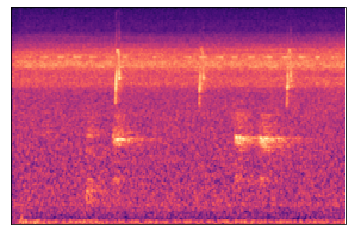

In [48]:
print("shape:", next(iter(audio_image_store.values())).shape)
lbd.specshow(next(iter(audio_image_store.values()))[0])

In [49]:
for k, v in LABEL_IDS.items():
    print(k, v)
    break

acafly 0


In [50]:
image_w = 281

def pad_image(image, image_w=image_w):
    h = image.shape[0]
    w = image.shape[1]
    if w < image_w:
        start = np.random.choice((image_w-w))
        ret = np.zeros((h, image_w))
        ret[:, start:start+w] = image
        return ret
    return image


class BirdClefDataset(Dataset):

    def __init__(
        self,
        audio_image_store,
        audio_prob_store,
        meta,
        sr=SR,
        is_train=True,
        num_classes=NUM_CLASSES,
        duration=DURATION,
    ):        
        self.audio_image_store = audio_image_store
        self.audio_prob_store = audio_prob_store
        self.meta = meta.copy().reset_index(drop=True)
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.eps = 0.0025
    
    @staticmethod
    def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        return image

    def __len__(self):
        return len(self.meta)
    
    def mixup_data(self, image, noize, alpha=0.5):
        if alpha > 0.:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1.
        lam /= 2 # leave it at half maximum.
        mixed_x = (1 - lam) * image + lam * noize
        return mixed_x

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        images = self.audio_image_store[row.filename]
        probs = self.audio_prob_store[row.filename]

        i = np.random.choice(len(images))
        image = images[i]

        if image.shape[1] < self.audio_length:
            image = pad_image(image, image_w)

        
        image = self.normalize(image)
        prob = probs[i]
        t = np.zeros(self.num_classes, dtype=np.float32) + self.eps # Label smoothing
        t[row.label_id] = max(min(prob, config.confidence_ub), self.eps) # clipping
        for secondary_label in row.secondary_labels:
            # Set a lower value than the primary label
            if secondary_label in LABEL_IDS:
                t[LABEL_IDS[secondary_label]] = max(self.eps, prob * 0.6)

        
        return image, t

In [51]:
ds = BirdClefDataset(audio_image_store, audio_prob_store, meta=df, sr=SR, duration=DURATION, is_train=True)
len(df)

100

(3, 128, 281) (397,) (array([0]),)


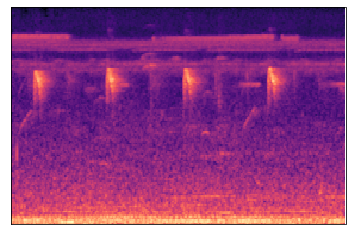

In [52]:
x, y = ds[np.random.choice(len(ds))]
# x, y = ds[0]
print(x.shape, y.shape, np.where(y >= 0.5))
lbd.specshow(x[0])

# Training the model

In [53]:
def mixup_data(x, y, alpha=0.5, use_cuda=True):
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    mixed_y = lam * y + (1 - lam) * y[index]
    #mixed_y = torch.maximum(y, y[index])
    return mixed_x, mixed_y, lam

In [54]:
def one_step( xb, yb, net, criterion, optimizer, scheduler=None):
  if config.use_mixup:
      xb, yb, lam = mixup_data(xb,yb, alpha=config.mixup_alpha)
  xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        
  optimizer.zero_grad()
  o = net(xb)
  loss = criterion(o, yb)
  loss.backward()
  optimizer.step()
  
  with torch.no_grad():
      l = loss.item()

      o = o.sigmoid()
      yb = (yb > 0.5 )*1.0
      lrap = label_ranking_average_precision_score(yb.cpu().numpy(), o.cpu().numpy())

      o = (o > 0.5)*1.0

      prec = (o*yb).sum()/(1e-6 + o.sum())
      rec = (o*yb).sum()/(1e-6 + yb.sum())
      f1 = 2*prec*rec/(1e-6+prec+rec)

  if  scheduler is not None:
    scheduler.step()

  return l, lrap, f1.item(), rec.item(), prec.item()

In [55]:
@torch.no_grad()
def evaluate(net, criterion, val_laoder):
    net.eval()

    os, y = [], []
    val_laoder = tqdm(val_laoder, leave = False, total=len(val_laoder))

    for icount, (xb, yb) in  enumerate(val_laoder):

        y.append(yb.to(DEVICE))

        xb = xb.to(DEVICE)
        o = net(xb)

        os.append(o)

    y = torch.cat(y)
    o = torch.cat(os)

    l = criterion(o, y).item()
    
    o = o.sigmoid()
    y = (y > 0.5)*1.0

    lrap = label_ranking_average_precision_score(y.cpu().numpy(), o.cpu().numpy())

    o = (o > 0.5)*1.0

    prec = ((o*y).sum()/(1e-6 + o.sum())).item()
    rec = ((o*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)

    return l, lrap, f1, rec, prec, 
    

In [56]:
def one_epoch(net, criterion, optimizer, scheduler, train_laoder, val_laoder):
  net.train()
  l, lrap, prec, rec, f1, icount = 0.,0.,0.,0., 0., 0
  train_laoder = tqdm(train_laoder, leave = False)
  epoch_bar = train_laoder
  
  for (xb, yb) in  epoch_bar:
      # epoch_bar.set_description("----|----|----|----|---->")
      _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
      l += _l
      lrap += _lrap
      f1 += _f1
      rec += _rec
      prec += _prec

      icount += 1
        
      if hasattr(epoch_bar, "set_postfix") and not icount%10:
          epoch_bar.set_postfix(
            loss="{:.6f}".format(l/icount),
            lrap="{:.3f}".format(lrap/icount),
            prec="{:.3f}".format(prec/icount),
            rec="{:.3f}".format(rec/icount),
            f1="{:.3f}".format(f1/icount),
          )
  
  scheduler.step()

  l /= icount
  lrap /= icount
  f1 /= icount
  rec /= icount
  prec /= icount
  
  l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_laoder)
  
  return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val)

In [57]:
class AutoSave:
  def __init__(self, top_k=50, metric="f1", mode="min", root=None, name="ckpt"):
    self.top_k = top_k
    self.logs = []
    self.metric = metric
    self.mode = mode
    self.root = Path(root or MODEL_ROOT)
    assert self.root.exists()
    self.name = name

    self.top_models = []
    self.top_metrics = []

  def log(self, model, metrics):
    metric = metrics[self.metric]
    rank = self.rank(metric)

    self.top_metrics.insert(rank+1, metric)
    if len(self.top_metrics) > self.top_k:
      self.top_metrics.pop(0)

    self.logs.append(metrics)
    self.save(model, metric, rank, metrics["epoch"])


  def save(self, model, metric, rank, epoch):
    t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
    name = re.sub(r"[^\w_-]", "", name) + ".pth"
    path = self.root.joinpath(name)

    old_model = None
    self.top_models.insert(rank+1, name)
    if len(self.top_models) > self.top_k:
      old_model = self.root.joinpath(self.top_models[0])
      self.top_models.pop(0)      

    torch.save(model.state_dict(), path.as_posix())

    if old_model is not None:
      old_model.unlink()

    self.to_json()


  def rank(self, val):
    r = -1
    for top_val in self.top_metrics:
      if val <= top_val:
        return r
      r += 1

    return r
  
  def to_json(self):
    # t = time.strftime("%Y%m%d%H%M%S")
    name = "{}_logs".format(self.name)
    name = re.sub(r"[^\w_-]", "", name) + ".json"
    path = self.root.joinpath(name)

    with path.open("w") as f:
      json.dump(self.logs, f, indent=2)


In [58]:
def one_fold(model_name, fold, train_set, val_set, epochs=20, save=True, save_root=None):

  save_root = Path(save_root) or MODEL_ROOT

  saver = AutoSave(root=save_root, name=f"birdclef_{model_name}_fold{fold}", metric="f1_val")

  net = get_model(model_name).to(DEVICE)

  #criterion = nn.BCEWithLogitsLoss()
  weight = None
  if config.use_weight:
      label_inv = (1/df["label_id"].value_counts().sort_index()).values
      label_inv_mean = label_inv.mean()
      weight = label_inv*(1/label_inv_mean)  # Inverse proportion such that the mean is 1
      weight = torch.tensor(weight).to(DEVICE)
  criterion = nn.BCEWithLogitsLoss(weight=weight)
  
  lr =  8e-4
  optimizer = optim.Adam(net.parameters(), lr=lr)
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs)

  train_data = BirdClefDataset(
      audio_image_store,
      audio_prob_store,
      meta=df.iloc[train_set].reset_index(drop=True),
      sr=SR,
      duration=DURATION,
      is_train=True
    )
  train_laoder = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, num_workers=TRAIN_NUM_WORKERS, shuffle=True, pin_memory=True)

  val_data = BirdClefDataset(
      audio_image_store,
      audio_prob_store,
      meta=df.iloc[val_set].reset_index(drop=True),
      sr=SR,
      duration=DURATION,
      is_train=False)
  val_laoder = DataLoader(val_data, batch_size=VAL_BATCH_SIZE, num_workers=VAL_NUM_WORKERS, shuffle=False)

  epochs_bar = tqdm(list(range(epochs)), leave=False)
  for epoch  in epochs_bar:
    epochs_bar.set_description(f"--> [EPOCH {epoch:02d}]")
    net.train()

    (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val) = one_epoch(
        net=net,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_laoder=train_laoder,
        val_laoder=val_laoder,
      )

    epochs_bar.set_postfix(
        loss="({:.6f}, {:.6f})".format(l, l_val),
        prec="({:.3f}, {:.3f})".format(prec, prec_val),
        rec="({:.3f}, {:.3f})".format(rec, rec_val),
        f1="({:.3f}, {:.3f})".format(f1, f1_val),
        lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
    )

    print(
        "[{epoch:02d}] loss: {loss} lrap: {lrap} f1: {f1} rec: {rec} prec: {prec}".format(
            epoch=epoch,
            loss="({:.6f}, {:.6f})".format(l, l_val),
            prec="({:.3f}, {:.3f})".format(prec, prec_val),
            rec="({:.3f}, {:.3f})".format(rec, rec_val),
            f1="({:.3f}, {:.3f})".format(f1, f1_val),
            lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
        )
    )

    if save:
      metrics = {
          "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
          "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
          "epoch": epoch,
      }

      saver.log(net, metrics)

In [59]:
def train(model_name, epochs=20, save=True, n_splits=5, seed=177, save_root=None, suffix="", folds=None):
  gc.collect()
  torch.cuda.empty_cache()

  save_root = save_root or MODEL_ROOT/f"{model_name}{suffix}"
  save_root.mkdir(exist_ok=True, parents=True)
  
  fold_bar = tqdm(df.reset_index().groupby("fold").index.apply(list).items(), total=df.fold.max()+1)
  
  for fold, val_set in fold_bar:
      if folds and not fold in folds:
        continue
      
      print(f"\n############################### [FOLD {fold}]")
      fold_bar.set_description(f"[FOLD {fold}]")
      train_set = np.setdiff1d(df.index, val_set)
        
      one_fold(model_name, fold=fold, train_set=train_set , val_set=val_set , epochs=epochs, save=save, save_root=save_root)
    
      gc.collect()
      torch.cuda.empty_cache()

In [60]:
for model_name in MODEL_NAMES:
    print("\n\n###########################################", model_name.upper())
    train(model_name, epochs=config.epochs, suffix=config.suffix, folds=config.folds)



########################################### RESNEST26D


  0%|          | 0/5 [00:00<?, ?it/s]


############################### [FOLD 0]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[00] loss: (0.615010, 0.354353) lrap: (0.424, 0.717) f1: (0.047, 0.379) rec: (0.606, 0.383) prec: (0.025, 0.375)
